# Clustering Analysis - CLIQUE results

In [1]:
# Imports
import pickle
import pandas as pd
from tqdm import tqdm

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

### Data

In [2]:
threshold_pruning = 0.5 # dataset: 0.57 with zeros

In [3]:
# Data
dataset_folder = 'data'
cluster_file_path = '%s/%s' % (dataset_folder, 'clique-cluster.bin')
data_norm = pd.read_csv('%s/%s' % (dataset_folder, 'platform-game-without-class.txt'), header=None, sep=' ')
data_real = pd.read_csv('%s/%s' % (dataset_folder, 'platform-game.csv'), sep=',')
columns = pickle.load(open('%s/%s' % (dataset_folder, 'platform-game-column.bin'), 'rb'))

# Clusters
df = pickle.load(open(cluster_file_path, "rb"))
print("clusters:",len(df))

clusters: 3573


## Cluster Analysis

### Display Clusters by Dimenson

In [4]:
cluster_dimension = {x:[] for x in range(1,13)}
for cluster in df:
    dimension = len(cluster["dimension"])
    cluster_dimension[dimension].append(cluster)

print('Clusters by dimension')
for key, clusters in cluster_dimension.items():
    print(key, len(clusters))

del cluster_dimension

Clusters by dimension
1 16
2 180
3 554
4 945
5 955
6 620
7 168
8 103
9 32
10 0
11 0
12 0


### Threshold Percent of Zeros

In [5]:
def getDimension(cluster,column="dimension"):
    return [int(x)-1 for x in cluster[column]]


def getElements(cluster):
    return [int(el)-1 for el in cluster["element"]]


def percentZeros(df,cluster):
    # cluster
    cluster_columns = getDimension(cluster)
    cluster_elements = getElements(cluster)
    # selected data
    df_data = df.loc[cluster_elements,cluster_columns].astype(bool)
    zeros     = (df_data == False).sum().sum()
    non_zeros = (df_data == True).sum().sum()
    percent = zeros/(zeros+non_zeros)
    return percent

In [6]:
def getClustersThreshold(threshold=0.5):
    df_threshold = []
    for cluster in tqdm(df,desc="Threshold"):
        percent = percentZeros(data_norm,cluster)
        if percent <= threshold:
            df_threshold.append(cluster)
    return df_threshold

In [7]:
df_clean = getClustersThreshold(threshold_pruning)

Threshold: 100%|██████████| 3573/3573 [00:03<00:00, 1111.32it/s]


In [8]:
'percent <= %.2f - clusters %d' % (threshold_pruning, len(df_clean))

'percent <= 0.50 - clusters 790'

Order the cluster by the number of elements (courses)

In [9]:
def numberOfElements(cluster):
    return len(cluster['element'])


def intervalRule(df,cluster):
    # selected data
    cluster_columns = getDimension(cluster)
    cluster_columns = df.columns[cluster_columns]
    cluster_elements = getElements(cluster)
    df_data = df.loc[cluster_elements,cluster_columns]
    # interval
    df_data_max = df_data.max()
    df_data_min = df_data.min()
    values = [(df_data_min[column], df_data_max[column]) for column in cluster_columns]
    return values,cluster_columns.tolist()


# -- remove zero columns
def intervalRuleFalsed(df,cluster):
    intervals_values,dimension_columns = intervalRule(data_real,cluster)
    for interval in intervals_values:
        if interval[1] == 0:
            return False,False
    return intervals_values,dimension_columns

In [10]:
df_clean.sort(key=numberOfElements,reverse=True)

Remove clusters with zero interval, and coverage min

In [11]:
df_itemset = pd.DataFrame(columns=['cluster','coverage','dimension','dimension.set','interval'])
for idx,cluster in enumerate(df_clean):
    elements_count = numberOfElements(cluster)
    intervals_values,dimension_columns = intervalRuleFalsed(data_real,cluster)
    if intervals_values and dimension_columns:
        df_itemset.loc[idx] = [cluster['number'],elements_count,dimension_columns,set(dimension_columns),intervals_values]

'Without zero interval:', len(df_itemset)

('Without zero interval:', 318)

### Cutoff Head

In [12]:
# data
itemset_columns = ['cluster','coverage','dimension','interval']
# print
df_itemset[itemset_columns].head(7)

,cluster,coverage,dimension,interval
0,3,718,[harmful-indestructible-fixedBig],"[(0, 102)]"
1,4,718,[friendly-teleport],"[(0, 150)]"
2,5,717,[harmful-indestructible-fixed],"[(0, 1557)]"
3,12,715,[harmful-indestructible-shooter],"[(0, 84)]"
4,15,715,[friendly-help],"[(0, 773)]"
5,6,713,[friendly-powerUp],"[(0, 140)]"
6,10,712,[friendly-coin],"[(0, 595)]"


In [13]:
dim = ['harmful-indestructible-fixedBig','friendly-teleport','harmful-indestructible-fixed',
       'harmful-indestructible-shooter','friendly-help','friendly-powerUp','friendly-coin']
data_real[dim].max()

harmful-indestructible-fixedBig     170
friendly-teleport                   220
harmful-indestructible-fixed       2005
harmful-indestructible-shooter      121
friendly-help                      1999
friendly-powerUp                    200
friendly-coin                      1570
dtype: int64

In [14]:
df_itemset[itemset_columns].iloc[7:25]

,cluster,coverage,dimension,interval
7,28,702,"[harmful-breakable-flyBig, harmful-indestructi...","[(0, 9), (0, 1557)]"
8,145,650,"[friendly-vehicle, friendly-help]","[(0, 5), (0, 773)]"
9,163,645,"[friendly-help, friendly-coin]","[(0, 191), (0, 595)]"
10,157,643,"[friendly-help, friendly-teleport]","[(0, 191), (0, 98)]"
11,553,640,"[harmful-indestructible-shooterFly, friendly-h...","[(0, 2), (0, 191), (0, 595)]"
12,582,640,"[harmful-breakable-shooterFlyBig, friendly-hel...","[(0, 1), (0, 191), (0, 582)]"
13,547,638,"[harmful-indestructible-shooterFly, friendly-h...","[(0, 2), (0, 191), (0, 98)]"
14,671,638,"[harmful-breakable-shooterFlyBig, friendly-hel...","[(0, 1), (0, 191), (0, 98)]"
15,516,632,"[harmful-breakable-flyBig, friendly-help, frie...","[(0, 9), (0, 191), (0, 595)]"
16,708,630,"[harmful-breakable-flyBig, friendly-help, frie...","[(0, 9), (0, 191), (0, 98)]"


#### Plot

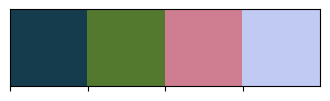

In [15]:
# palette of colors
palette = sns.color_palette('cubehelix', 4)
sns.palplot(palette)

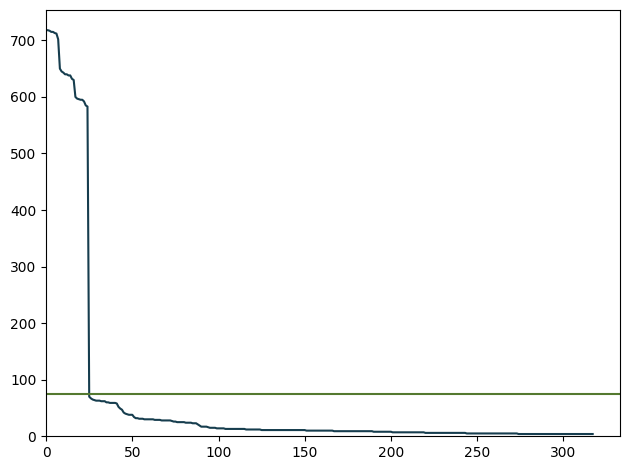

In [16]:
# values
labels = range(len(df_itemset))
values = df_itemset['coverage'].tolist()
cutoff = 75

# plot
fig, ax = plt.subplots()
ax.plot(values, color=palette[0])
plt.axhline(cutoff, color=palette[1])

# figure
ax.set_xlim(0)
ax.set_ylim(0)

# ax.axis('equal')
# ax.set_yscale('log')
# plt.yticks(range(min(values), max(values), 18), range(min(values), max(values), 18))

plt.tight_layout()
# plt.savefig('%s/%s.pdf' % (plot_folder, 'difficulty'), dpi=300, bbox_inches='tight')
plt.show()

### Cutoff Tail

In [17]:
# filtering the clusters if a coverage
df_itemset_tail = df_itemset.iloc[25:84]
# copying the filtered DataFrame
df_itemset_tail = df_itemset_tail.copy()

print('cluster: %d of %d' % (len(df_itemset_tail), len(df_itemset.iloc[25:])))

cluster: 59 of 293


In [18]:
df_itemset_tail.loc[:, 'dimension.size'] = df_itemset_tail.apply(lambda x: len(x['dimension']), axis=1).tolist()
df_itemset_tail = df_itemset_tail.sort_values(by=['dimension.size'], ascending=False)

In [19]:
# storing clustering results
df_itemset_tail.to_parquet('%s/%s' % (dataset_folder, 'cluster-items.parquet'))

#### Plot

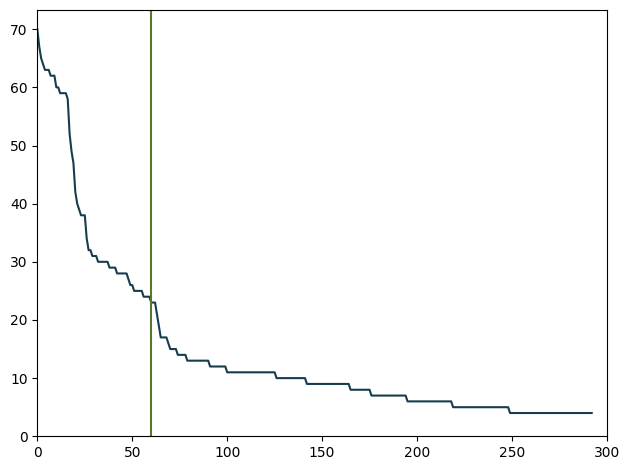

In [20]:
# values
values = df_itemset.iloc[25:]['coverage'].tolist()
cutoff = 60

# plot
fig, ax = plt.subplots()
ax.plot(values, color=palette[0])
plt.axvline(cutoff, color=palette[1])

# figure
ax.set_xlim(0,300)
ax.set_ylim(0)

plt.tight_layout()
# plt.savefig('%s/%s.pdf' % (plot_folder, 'difficulty'), dpi=300, bbox_inches='tight')
plt.show()

All of the selected clusters

In [21]:
print("Lines %d, columns %d" % df_itemset_tail[itemset_columns].shape)
df_itemset_tail[itemset_columns]

Lines 59, columns 4


,cluster,coverage,dimension,interval
120,2989,25,"[harmful-breakable-flyBig, harmful-breakable-s...","[(0, 5), (0, 1), (0, 2), (6, 11), (0, 154), (0..."
110,2489,26,"[harmful-breakable-shooterFlyBig, harmful-inde...","[(0, 1), (0, 2), (6, 11), (0, 154), (0, 250)]"
111,2532,26,"[harmful-breakable-flyBig, harmful-breakable-s...","[(0, 5), (0, 1), (6, 11), (0, 154), (0, 250)]"
119,2542,25,"[harmful-breakable-flyBig, harmful-indestructi...","[(0, 5), (0, 2), (6, 11), (0, 154), (0, 250)]"
125,1306,24,"[harmful-breakable-flyBig, harmful-breakable-s...","[(0, 6), (0, 1), (35, 51), (0, 398)]"
106,1347,27,"[harmful-breakable-flyBig, harmful-indestructi...","[(0, 5), (0, 2), (6, 11), (0, 250)]"
76,1620,38,"[harmful-breakable-flyBig, harmful-breakable-s...","[(0, 4), (0, 3), (206, 399), (0, 39)]"
80,1250,32,"[harmful-breakable-shooterBig, harmful-indestr...","[(0, 5), (25, 36), (0, 2), (0, 176)]"
83,1421,31,"[harmful-breakable-flyBig, harmful-breakable-s...","[(0, 6), (0, 5), (25, 36), (0, 176)]"
89,1123,30,"[harmful-breakable-shooterFlyBig, harmful-inde...","[(0, 1), (0, 2), (6, 11), (0, 154)]"


In [22]:
# -- Without the dimensions (exclud)
def withoutDimension(df, exclud=[]):
    idxs, conds = [], []
    n = len(exclud)
    for idx, row in df.iterrows():
        idxs.append(idx)
        dims = [dim not in row['dimension'] for dim in exclud]
        conds.append(sum(dims) == n)
    print('without: %d' % sum(conds), exclud)
    return pd.Series(conds, index=idxs)


# -- With the dimensions (includ)
def withDimension(df, includ=[]):
    idxs, conds = [], []
    n = len(includ)
    for idx, row in df.iterrows():
        idxs.append(idx)
        dims = [dim in row['dimension'] for dim in includ]
        conds.append(sum(dims) == n)
    print('with: %d' % sum(conds), includ)
    return pd.Series(conds, index=idxs)

Removing `'friendly-help'` dimension

In [23]:
df_itemset_tail[withoutDimension(df_itemset_tail, ['friendly-help'])][itemset_columns]

without: 18 ['friendly-help']


,cluster,coverage,dimension,interval
106,1347,27,"[harmful-breakable-flyBig, harmful-indestructi...","[(0, 5), (0, 2), (6, 11), (0, 250)]"
101,1398,28,"[harmful-breakable-shooterFlyBig, harmful-inde...","[(0, 1), (0, 2), (6, 11), (0, 250)]"
102,1452,28,"[harmful-breakable-flyBig, harmful-breakable-s...","[(0, 5), (0, 1), (6, 11), (0, 250)]"
30,688,65,"[harmful-breakable-flyBig, harmful-indestructi...","[(0, 5), (18, 34), (0, 11)]"
98,703,28,"[harmful-breakable-flyBig, friendly-vehicle, f...","[(0, 5), (6, 11), (0, 250)]"
97,682,28,"[harmful-indestructible-shooterFly, friendly-v...","[(0, 2), (6, 11), (0, 250)]"
93,739,29,"[harmful-breakable-shooterFlyBig, friendly-veh...","[(0, 1), (6, 11), (0, 250)]"
87,610,30,"[harmful-indestructible-shooter, harmful-indes...","[(25, 36), (0, 2), (0, 11)]"
51,641,58,"[harmful-breakable-shooterBig, harmful-indestr...","[(0, 5), (201, 392), (0, 11)]"
123,689,24,"[harmful-breakable-flyBig, harmful-indestructi...","[(0, 6), (35, 51), (0, 3)]"


Without items

In [24]:
df_itemset_tail[withoutDimension(df_itemset_tail, ['friendly-help','friendly-vehicle','friendly-coin'])][itemset_columns]

without: 2 ['friendly-help', 'friendly-vehicle', 'friendly-coin']


,cluster,coverage,dimension,interval
25,38,70,"[harmful-indestructible-fixedBig, harmful-inde...","[(18, 34), (0, 2)]"
78,110,34,"[harmful-indestructible-shooter, harmful-indes...","[(25, 36), (0, 2)]"
